# Word features only on toxic

The idea is to construct word features with tf-idf and word2vec and then train a simple model such as logistic regression. 

## Quick look at the shape of the data

In [1]:
import pandas as pd

data = pd.read_csv("./data/raw-data/train.csv", usecols=["id", "comment_text", "toxic"])

In [2]:
data.shape

(159571, 3)

In [3]:
data.describe()

,toxic
count,159571.000000
mean,0.095844
std,0.294379
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Features on split train dataset

### Train/test split

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=543553)

In [5]:
trainIndex, testIndex = list(split.split(data, data.toxic))[0]

In [6]:
train, test = data.iloc[trainIndex], data.iloc[testIndex]

### Word2Vec

In [87]:
def splitSentences(dataset):
    return (dataset.comment_text
    .str.replace("[^A-Za-z\s]", "")
    .str.lower()
    .str.split())

In [88]:
%%time
splitTrain = splitSentences(train)
splitTest = splitSentences(test)

CPU times: user 2.94 s, sys: 144 ms, total: 3.09 s
Wall time: 3.09 s


In [10]:
%%time
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format(
    "/home/mariosk/Documents/common-ml-models/GoogleNews-vectors-negative300.bin", 
    binary=True)  

CPU times: user 52.4 s, sys: 5.79 s, total: 58.2 s
Wall time: 58.4 s


In [11]:
%%time
vocabulary = set(model.wv.vocab.keys())

CPU times: user 364 ms, sys: 28 ms, total: 392 ms
Wall time: 389 ms


In [46]:
%%time
def wordsToVector(words):
    allowedWords = [word for word in words if word in vocabulary]
    
    return model.wv[allowedWords if allowedWords else ["hello"]].mean(axis=0)

CPU times: user 25.8 s, sys: 84 ms, total: 25.9 s
Wall time: 25.9 s


In [ ]:
import numpy as np

In [ ]:
%%time
w2vTrainFeatures = np.array(splitTrain.apply(wordsToVector).tolist())

In [49]:
%%time
w2vTestFeatures = np.array(splitTest.apply(wordsToVector).tolist())

CPU times: user 6.48 s, sys: 0 ns, total: 6.48 s
Wall time: 6.48 s


### Tf-idf features

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer().fit(train.comment_text)

In [8]:
tfidfTrainFeatures = tfidf.transform(train.comment_text)

/home/mariosk/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [9]:
tfidfTestFeatures = tfidf.transform(test.comment_text)

/home/mariosk/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [10]:
trainFeatures = tfidfTrainFeatures
testFeatures = tfidfTestFeatures

## Logistic regression

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(trainFeatures, train.toxic)

In [12]:
testPredictions = model.predict(testFeatures)

In [13]:
testProbPredictions = model.predict_proba(testFeatures)

In [14]:
from sklearn.metrics import confusion_matrix, f1_score, log_loss, roc_auc_score

def getMetrics(label, predictions, probPredictions):
    return {"Confusion Matrix": pd.DataFrame(
                data=confusion_matrix(label, predictions),
                index=["T Neutral", "T Toxic"],
                columns=["P Neutral", "P Toxic"]), 
            "Relativized Confusion Matrix": pd.DataFrame(
                data=confusion_matrix(label, predictions) / float(len(predictions)),
                index=["T Neutral", "T Toxic"],
                columns=["P Neutral", "P Toxic"]),
            "F1 score": round(f1_score(label, predictions, pos_label=1.0), 3),
            "Logarithmic loss": round(log_loss(label, probPredictions), 4),
            "Area under ROC": roc_auc_score(label, probPredictions[:, 1]) }

In [16]:
import numpy as np
np.set_printoptions(precision=4, suppress=True)

In [17]:
from IPython.display import HTML, display

def printMetrics(metrics):
    for (name, value) in metrics.items():
        display(HTML("<div style='font-weight:bold'>{} :</div>".format(name)))
        print(value)

## Print metrics for test dataset

In [18]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def showROC(labels, probPredictions):
    fpr, tpr, _ = roc_curve(labels, probPredictions, pos_label=1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.plot([0, 1], [0, 1], color="darkorange", linestyle="--")
    plt.plot(fpr, tpr, color="steelblue")
    plt.show()

           P Neutral  P Toxic
T Neutral      28690      166
T Toxic         1219     1840


           P Neutral   P Toxic
T Neutral   0.898950  0.005201
T Toxic     0.038195  0.057653


0.727


0.117


0.972023163026236


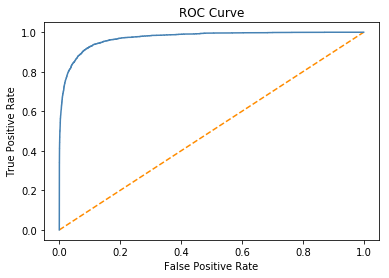

In [19]:
printMetrics(getMetrics(test.toxic, testPredictions, testProbPredictions))
showROC(test.toxic.as_matrix(), testProbPredictions[:, 1])

## Print metrics for train dataset

           P Neutral  P Toxic
T Neutral     114962      459
T Toxic         4435     7800


           P Neutral   P Toxic
T Neutral   0.900561  0.003596
T Toxic     0.034742  0.061102


0.761


0.1022


0.9842838590787909


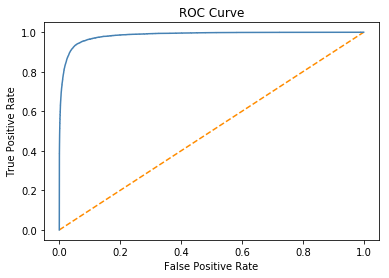

In [20]:
trainPredictions = model.predict(trainFeatures)
trainProbPredictions = model.predict_proba(trainFeatures)

printMetrics(getMetrics(train.toxic, trainPredictions, trainProbPredictions))
showROC(train.toxic.as_matrix(), trainProbPredictions[:, 1])

### Play with the model

In [21]:
def predict(sentence):
    return round(model.predict_proba(tfidf.transform([sentence]))[0][1], 3)

In [22]:
predict("<enter bad word here>")

/home/mariosk/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


0.131

## Export TP, FN and FP values

In [23]:
predictionsDF = pd.DataFrame(testProbPredictions[:, 1], columns=["prediction"])
zeroIndexedTest = test.reset_index().drop(["index"], axis=1)

testEvaluations = pd.concat([zeroIndexedTest, predictionsDF], axis=1)

In [24]:
tp = testEvaluations[(testEvaluations.toxic == 1) & (testEvaluations.prediction > 0.5)]
fn = testEvaluations[(testEvaluations.toxic == 1) & (testEvaluations.prediction <= 0.5)]
fp = testEvaluations[(testEvaluations.toxic == 0) & (testEvaluations.prediction > 0.5)]

In [25]:
print("Counts:\nTP: {}\nFN: {}\nFP: {}".format(tp.shape[0], fn.shape[0], fp.shape[0]))

Counts:
TP: 1840
FN: 1219
FP: 166


In [30]:
(tp[["toxic", "prediction", "id", "comment_text"]]
    .sort_values(["prediction"], ascending=False)
    .to_csv("./data/false-predictions/tf-idf/tp.csv", index=False))
(fn[["toxic", "prediction", "id", "comment_text"]]
    .sort_values(["prediction"], ascending=False)
    .to_csv("./data/false-predictions/tf-idf/fn.csv", index=False))
(fp[["toxic", "prediction", "id", "comment_text"]]
    .sort_values(["prediction"], ascending=False)
    .to_csv("./data/false-predictions/tf-idf/fp.csv", index=False))